In [1]:
############ START BOILERPLATE ############
#### Interactivity -- BOKEH
from bokeh.io import output_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
############ END BOILERPLATE ############
output_notebook()

Loading BokehJS ...

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../source")
from Match_Analytics import Match
from Tracking_Dynamics import calc_player_norm_positions
from Tracking_Visualization import plot_sliding_window
from Tracking_Filters import possesion_filter, ball_position_filter, time_window
from Tracking_Statistics import bivariate_normal_distribution

In [3]:
m1 = Match(data_source = 'metrica-sports', match_id = 2)

Initializing match: 2

Reading team: home
Reading team: away
Filtering dead time...

Match preprocessed successfully.



In [4]:
possesion_away, defense_home = possesion_filter(m1, possesion_team='Away')

In [5]:
defense_home, possesion_away = ball_position_filter(m1,home_df =defense_home, 
                                                    away_df = possesion_away, left_bound= -10, right_bound = 10)

In [138]:
plot_sliding_window(m1)

In [146]:
df = bivariate_normal_distribution(time_window(possesion_away, start = 1, end = 1001), m1.away_players).set_index("player")
df

,player_number,x_mean,y_mean,normx_mean,normy_mean,cov_x_std,cov_y_std,cov_angle,x_std,y_std,cov_normx_std,cov_normy_std,cov_norm_angle,normx_std,normy_std
player,,,,,,,,,,,,,,,
Away_15,15,-1.346424,-23.456354,-0.117958,-1.439430,12.815334,5.799491,0.310618,12.330134,6.770130,0.301346,0.134871,0.005068,0.301343,0.134878
Away_16,16,-11.005733,-9.806521,-0.741537,-0.574683,9.509331,8.432412,0.222593,9.459690,8.488063,0.184208,0.247718,0.539779,0.202925,0.232634
Away_17,17,-10.511464,7.891230,-0.708773,0.535992,9.856899,7.007877,-0.174335,9.783296,7.110268,0.155822,0.195589,0.688138,0.172966,0.180606
Away_18,18,0.828537,22.590384,0.032293,1.461380,12.692609,5.394229,-0.276878,12.297910,6.241908,0.373984,0.217173,-0.773054,0.307665,0.303924
Away_19,19,11.432709,-23.764476,0.728779,-1.467137,11.141300,6.068438,0.180796,11.013893,6.296719,0.220854,0.369632,-0.020391,0.220936,0.369583
Away_20,20,-0.501568,1.576485,-0.054625,0.151791,9.906679,10.669065,0.099738,9.914525,10.661774,0.203472,0.502295,0.208398,0.224562,0.493227
Away_21,21,3.115083,-5.589294,0.185274,-0.310233,8.873637,10.355755,-0.699892,9.516641,9.768144,0.166202,0.393038,0.105149,0.170354,0.391257
Away_22,22,12.834397,21.947623,0.819953,1.432653,10.855493,12.839937,-0.678196,11.676921,12.097736,0.311614,0.618520,0.022762,0.311851,0.618400
Away_23,23,17.497585,4.268689,1.129507,0.302194,10.469589,8.810226,0.161723,10.429901,8.857174,0.194352,0.444247,0.078052,0.196832,0.443154


In [121]:
def mean_quadratic_distance(window=60*10, step=30, team = defense_home, players = m1.home_players, axis = "x"):
    lower_time = 0
    upper_time = window
    period_df = time_window(team, start = lower_time, end = upper_time)
    r = np.empty(0)
    t = np.empty(0)
    r_player = {}
    x = {}
    y = {}
    tactics = []
    previous = bivariate_normal_distribution(period_df, players).set_index("player")
    current_r=0
    last_index = 0
    for player in players:
        try:
            x[player]=previous.loc[player]['normx_mean']
            y[player]=previous.loc[player]['normy_mean']
        except:
            pass
        r_player[player] = np.empty(0)
    while period_df['Time [s]'].max() < team['Time [s]'].max():
        lower_time += step
        upper_time += step
        period_df = time_window(team, start = lower_time, end = upper_time)
        bivariate = bivariate_normal_distribution(period_df, players).set_index("player")
        dqm=0
        N=0
        for player in players:
            try:
                dq = (bivariate.loc[player][f'norm{axis}_mean'])
                dqm += dq
                r_player[player] = np.append(r_player[player], dq)
                N+=1
            except:
                r_player[player] = np.append(r_player[player], np.nan)
                pass
        try:
            r = np.append(r, dqm/N)
            t = np.append(t, lower_time+window/2)
            if dqm/N > current_r + 10*np.std(r[last_index:]):
                for player in players:
                    try:
                        x[player]=bivariate.loc[player]['normx_mean']
                        y[player]=bivariate.loc[player]['normy_mean']
                    except:
                        print("Error")
                        pass
                current_r = dqm/N
                last_index = len(r)
                print(last_index)
                tactics.append(lower_time+window/2)
        except:
            r = np.append(r, np.nan)
            t = np.append(t, np.nan)
            print("Error")
            pass
    return r, t, r_player


Error
1
224
Error
Error
Error
1
Error
Error
Error
2
Error
Error
Error
3
Error
Error
Error
4
Error
Error
Error
5
Error
Error
Error
6
Error
Error
Error
7
Error
Error
Error
8
Error
Error
Error
9
Error
Error
Error
10


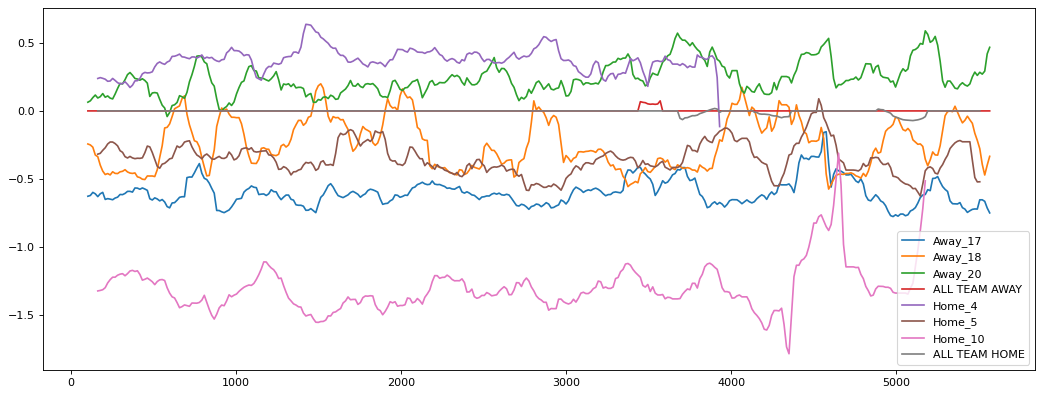

In [122]:
r,t,r_player = mean_quadratic_distance(60*3,15, m1.tracking_away, players=m1.away_players)
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Away_17", "Away_18", "Away_20"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM AWAY")
r,t,r_player = mean_quadratic_distance(60*5,15, team=m1.tracking_home, players=m1.home_players)
for player in ["Home_4", "Home_5", "Home_10"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM HOME")
plt.legend()

224
225
Error
Error
Error
1
Error
Error
Error
2
Error
Error
Error
3
Error
Error
Error
4
Error
Error
Error
5
Error
Error
Error
6
Error
Error
Error
7
Error
Error
Error
8
Error
Error
Error
9
Error
Error
Error
10


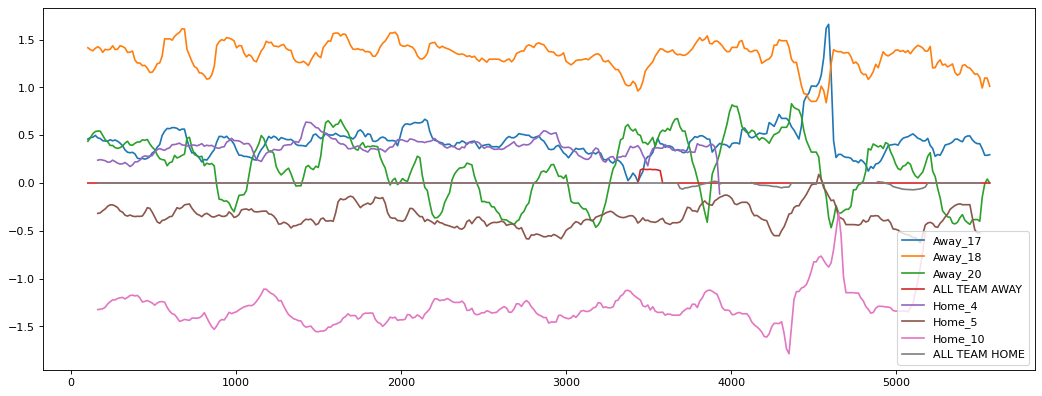

In [123]:
r,t,r_player = mean_quadratic_distance(60*3,15, m1.tracking_away, players=m1.away_players, axis = "y")
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Away_17", "Away_18", "Away_20"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM AWAY")
r,t,r_player = mean_quadratic_distance(60*5,15, team=m1.tracking_home, players=m1.home_players)
for player in ["Home_4", "Home_5", "Home_10"]:
    try:
        plt.plot(t, r_player[player], label=f"{player}")
        pass
    except:
        pass   
plt.plot(t, r, label="ALL TEAM HOME")
plt.legend()

In [124]:
indices = m1.events[m1.events["Type"] == "SET PIECE"].index[1:]
lower = m1.events.iloc[indices-1]['End Time [s]']
lower.index = indices
upper = m1.events.iloc[indices]['Start Time [s]']

ranges = pd.concat([lower,upper], axis=1)
filtered_home_df = m1.tracking_home
filtered_away_df = m1.tracking_away
for period in ranges.iterrows():
    filtered_home_df = filtered_home_df[~filtered_home_df['Time [s]'].between(period[1][0], period[1][1])]
    filtered_away_df = filtered_away_df[~filtered_away_df['Time [s]'].between(period[1][0], period[1][1])]

In [129]:
def rolling_window(tracking_data, players = None, window=5):
    temp_df = tracking_data[["Period", "Time [s]"]].copy()
    window = int(window/0.04)
    temp_df["mqd"] = 0
    
    for player in players:
        temp_df[f"{player}_x"] = tracking_data[f"{player}_x"].rolling(window).mean()
        temp_df[f"{player}_y"] = tracking_data[f"{player}_y"].rolling(window).mean()
        temp_df[f"{player}_normx"] = tracking_data[f"{player}_normx"].rolling(window).mean()
        temp_df[f"{player}_normy"] = tracking_data[f"{player}_normy"].rolling(window).mean()
        temp_df[f"{player}_vx"] = tracking_data[f"{player}_vx"].rolling(window).mean()
        temp_df[f"{player}_vy"] = tracking_data[f"{player}_vy"].rolling(window).mean()
        temp_df[f"{player}_std_x"] = tracking_data[f"{player}_x"].rolling(window).std()
        temp_df[f"{player}_std_y"] = tracking_data[f"{player}_y"].rolling(window).std()
        temp_df[f"{player}_std_normx"] = tracking_data[f"{player}_normx"].rolling(window).std()
        temp_df[f"{player}_std_normy"] = tracking_data[f"{player}_normy"].rolling(window).std()
        temp_df[f"{player}_std_vx"] = tracking_data[f"{player}_vx"].rolling(window).std()
        temp_df[f"{player}_std_vy"] = tracking_data[f"{player}_vy"].rolling(window).std()
        temp_df[f"{player}_max_vx"] = tracking_data[f"{player}_vx"].rolling(window).max()
        temp_df[f"{player}_min_vx"] = tracking_data[f"{player}_vx"].rolling(window).min()
        temp_df["mqd"] = temp_df["mqd"].add(
            ((tracking_data[f"{player}_normx"]-temp_df[f"{player}_normx"])**2+
            (tracking_data[f"{player}_normy"]-temp_df[f"{player}_normy"])**2)/11, fill_value=0)
    
    return temp_df

In [154]:
rolling = rolling_window(m1.tracking_home, m1.home_players, window = 60*1)

In [155]:
rolling_away = rolling_window(m1.tracking_away, m1.away_players, window = 60*1)

In [97]:
rolling.iloc[:1000]

,Period,Time [s],mqd,Home_1_x,Home_1_y,Home_1_normx,Home_1_normy,Home_1_vx,Home_1_vy,Home_1_std_x,...,Home_9_normy,Home_9_vx,Home_9_vy,Home_9_std_x,Home_9_std_y,Home_9_std_normx,Home_9_std_normy,Home_9_std_vx,Home_9_std_vy,Home_9_max_vx
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1,45.40,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,1,45.44,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1137,1,45.48,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


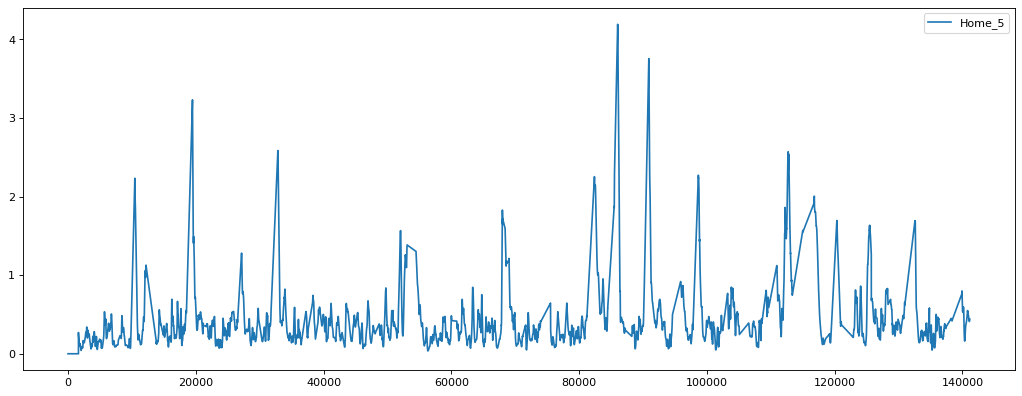

In [168]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Home_5"]:
    plt.plot(rolling["mqd"], label=f"{player}")
    
plt.legend()

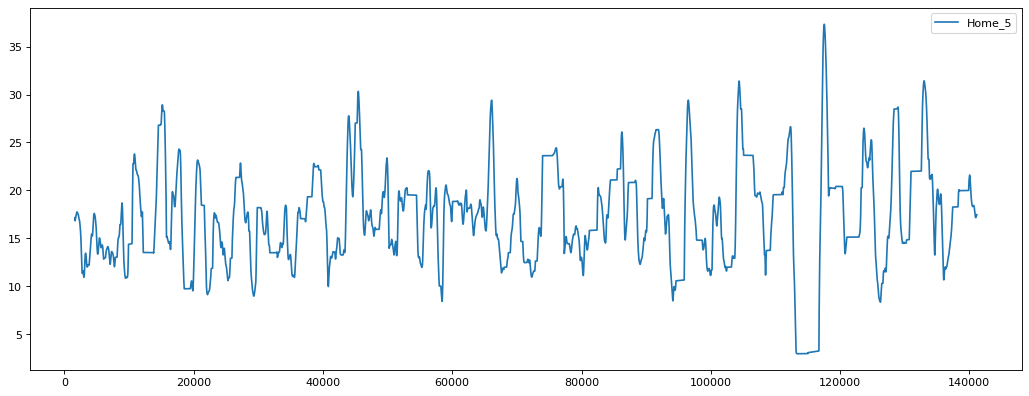

In [165]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in ["Home_5"]:
    plt.plot(np.sqrt(rolling[f"{player}_std_y"]**2+rolling[f"{player}_std_x"]**2), label=f"{player}")
    
plt.legend()

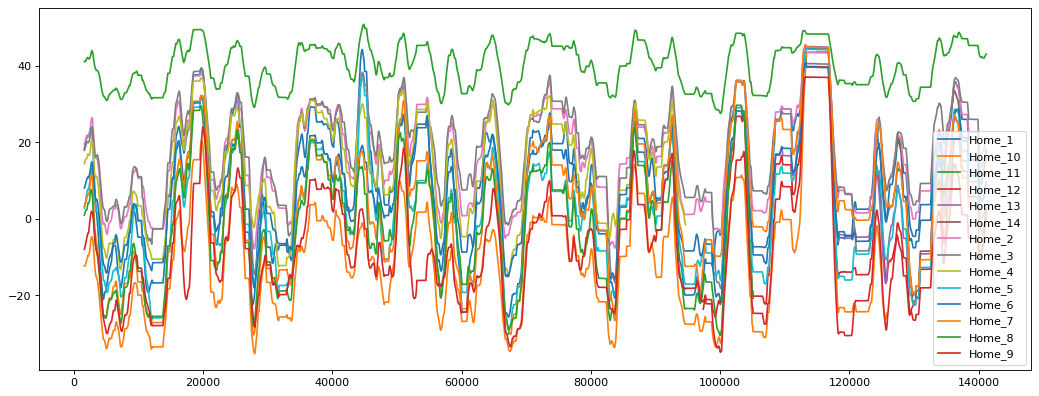

In [137]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in m1.home_players:
    plt.plot(rolling[f"{player}_x"], label=f"{player}")
    
plt.legend()

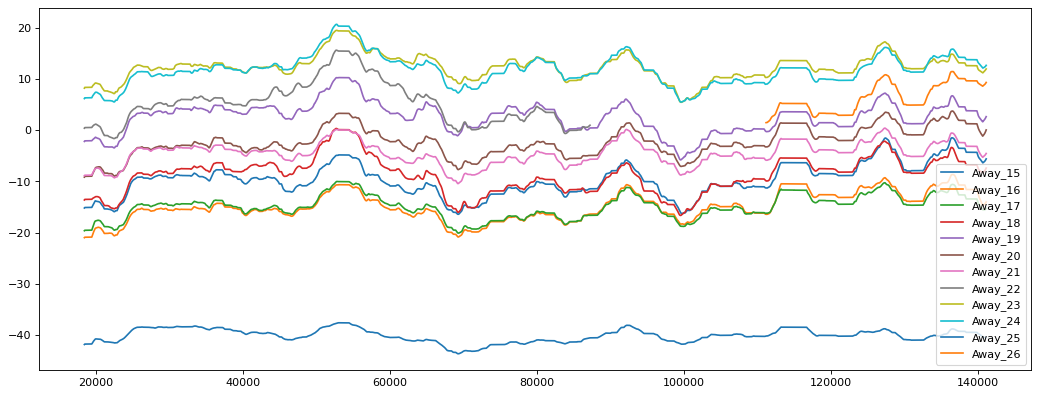

In [122]:
fig = plt.figure(figsize=(16, 6), dpi=80) 
for player in m1.away_players:
    plt.plot(rolling_away[f"{player}_x"], label=f"{player}")
    
plt.legend()

In [ ]:
final_data=m1.events[(m1.events['Type']=='PASS') & (m1.events['Team']=='Home')].groupby(['From','To','Start Time [s]','End Time [s]','Start X','Start Y','End X','End Y']).size().reset_index(name="Freq")

In [14]:
final_data

,From,To,Start Time [s],End Time [s],Start X,Start Y,End X,End Y,Freq
0,Home_1,Home_10,175.44,177.80,-1.06,-34.68,5.30,-23.12,1
1,Home_1,Home_10,1467.64,1468.72,-15.90,-17.68,-5.30,-12.24,1
2,Home_1,Home_2,225.08,226.52,-38.16,-6.80,-33.92,-2.04,1
3,Home_1,Home_2,643.76,645.36,3.18,-27.20,-15.90,-20.40,1
4,Home_1,Home_5,611.92,613.44,-6.36,-32.64,2.12,-29.92,1
...,...,...,...,...,...,...,...,...,...
432,Home_9,Home_6,1163.84,1164.48,-24.38,-6.80,-31.80,-4.08,1
433,Home_9,Home_6,2885.40,2886.40,1.06,-0.00,-11.66,1.36,1
434,Home_9,Home_7,1534.92,1535.52,13.78,11.56,4.24,8.16,1
435,Home_9,Home_8,4208.08,4208.68,14.84,25.16,11.66,32.64,1


In [15]:
size = final_data.groupby(['From','To']).sum().reset_index()
size

,From,To,Start Time [s],End Time [s],Start X,Start Y,End X,End Y,Freq
0,Home_1,Home_10,1643.08,1646.52,-16.96,-52.36,5.329071e-15,-35.36,2
1,Home_1,Home_2,868.84,871.88,-34.98,-34.00,-4.982000e+01,-22.44,2
2,Home_1,Home_5,1723.04,1725.32,-41.34,-53.04,-2.650000e+01,-57.12,2
3,Home_1,Home_6,641.80,642.64,2.12,-27.88,4.240000e+00,-15.64,1
4,Home_1,Home_7,1237.32,1238.52,10.60,-16.32,9.540000e+00,-8.16,1
...,...,...,...,...,...,...,...,...,...
120,Home_9,Home_4,6228.48,6232.84,121.90,70.72,1.113000e+02,98.60,4
121,Home_9,Home_5,616.76,617.20,14.84,-25.84,2.120000e+01,-25.84,1
122,Home_9,Home_6,5003.64,5005.80,-42.40,-6.12,-6.466000e+01,0.68,3
123,Home_9,Home_7,1534.92,1535.52,13.78,11.56,4.240000e+00,8.16,1


In [16]:
vals = np.unique(size[['From', 'To']])
df2 = pd.DataFrame(0, index=vals, columns=vals)
f = df2.index.get_indexer
df2.values[f(size.From), f(size.To)] = size.Freq.values
df2.to_numpy()

array([[ 0,  2,  0,  0,  0,  0,  2,  0,  0,  2,  1,  1,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  1,  5,  2,  7, 10,  1],
       [ 0,  0,  0,  2,  0,  1,  1,  1,  3,  3,  1,  2,  1,  2],
       [ 0,  9,  0,  0,  2,  1,  5,  4,  6,  6,  9,  4,  5,  2],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  1,  1,  0,  1,  1,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  1,  0,  0,  0,  2,  0,  2],
       [ 1,  0,  4,  5,  1,  2,  0,  7,  2,  3,  3, 12,  1,  3],
       [ 2,  0,  4,  5,  1,  1, 11,  0,  7,  1,  2,  3,  4,  0],
       [ 0,  3,  0,  6,  1,  0,  2, 10,  0,  1,  4,  2, 13,  5],
       [ 2,  6,  0,  2,  0,  0,  3,  1,  1,  0,  3, 11,  2,  3],
       [ 2, 10,  0,  9,  0,  0,  2,  6,  6,  4,  0,  4,  4,  1],
       [ 1,  7,  0,  9,  1,  3, 13,  1,  1,  8,  3,  0,  2,  3],
       [ 0,  4,  0,  7,  1,  0,  0,  2, 10,  0,  4,  0,  0,  3],
       [ 1,  1,  0,  3,  1,  1,  1,  0,  4,  1,  3,  1,  2,  0]])

In [17]:
from Tracking_Statistics import bivariate_normal_distribution
from Tracking_Filters import time_window

In [18]:
home_df = bivariate_normal_distribution(m1.tracking_away, m1.away_players)

home_df

,player_number,player,x_mean,y_mean,normx_mean,normy_mean,cov_x_std,cov_y_std,cov_angle,x_std,y_std,cov_normx_std,cov_normy_std,cov_norm_angle,normx_std,normy_std
0,15,Away_15,14.411639,11.357057,0.555538,0.941425,19.017633,8.200854,0.044696,19.002173,8.236612,0.356465,0.403915,0.283869,0.360413,0.400396
1,16,Away_16,15.966385,-0.941791,0.636475,-0.022351,15.946174,7.281258,0.082624,15.903133,7.374792,0.258380,0.386294,0.041456,0.258654,0.386111
2,17,Away_17,7.871638,6.970445,0.182551,0.609740,23.312690,17.264107,0.534389,21.904702,19.018805,0.436923,1.340200,-0.221870,0.518299,1.310879
3,18,Away_18,-3.424985,8.600321,-0.544630,0.740739,20.718248,15.564909,-0.091163,20.680816,15.614610,0.426183,1.120938,0.089251,0.436087,1.117122
4,19,Away_19,-0.633664,3.922333,-0.416383,0.370813,19.135164,12.600325,0.090360,19.090987,12.667158,0.305576,0.692921,-0.053789,0.307399,0.692114
5,20,Away_20,10.278246,-7.145387,0.289832,-0.517058,17.978829,10.123402,-0.034967,17.971324,10.136719,0.284039,0.583420,-0.244819,0.309734,0.570195
6,21,Away_21,2.021926,-3.734317,-0.219197,-0.250701,19.311157,13.401259,-0.182567,19.145452,13.636943,0.423095,0.742656,0.224655,0.444406,0.730103
7,22,Away_22,4.027300,-21.334377,-0.138480,-1.553007,21.763365,7.546773,-0.197230,21.392615,8.541303,0.542220,0.390003,-0.677578,0.488092,0.455929
8,23,Away_23,-13.731706,-2.130014,-1.247092,-0.126242,17.478597,12.889571,0.019095,17.477144,12.891542,0.387580,0.821538,0.059732,0.389984,0.820399
9,24,Away_24,-13.053088,-0.882836,-1.267668,0.037222,17.733821,11.455665,-0.009650,17.733340,11.456410,0.393704,0.736409,-0.107038,0.399278,0.733401


In [19]:
grouped = final_data.groupby(['From','To'])[['Start X','Start Y', 'End X', 'End Y']].mean().reset_index()
grouped['Pass X Mean'] = (grouped['Start X'] + grouped['End X'])/2
grouped['Pass Y Mean'] = (grouped['Start Y'] + grouped['End Y'])/2
grouped['X Mean'] = home_df['x_mean']
grouped['Y Mean'] = home_df['y_mean']
grouped

,From,To,Start X,Start Y,End X,End Y,Pass X Mean,Pass Y Mean,X Mean,Y Mean
0,Home_1,Home_10,-8.480000,-26.18,2.664535e-15,-17.680000,-4.240000,-21.930000,14.411639,11.357057
1,Home_1,Home_2,-17.490000,-17.00,-2.491000e+01,-11.220000,-21.200000,-14.110000,15.966385,-0.941791
2,Home_1,Home_5,-20.670000,-26.52,-1.325000e+01,-28.560000,-16.960000,-27.540000,7.871638,6.970445
3,Home_1,Home_6,2.120000,-27.88,4.240000e+00,-15.640000,3.180000,-21.760000,-3.424985,8.600321
4,Home_1,Home_7,10.600000,-16.32,9.540000e+00,-8.160000,10.070000,-12.240000,-0.633664,3.922333
...,...,...,...,...,...,...,...,...,...,...
120,Home_9,Home_4,30.475000,17.68,2.782500e+01,24.650000,29.150000,21.165000,NaN,NaN
121,Home_9,Home_5,14.840000,-25.84,2.120000e+01,-25.840000,18.020000,-25.840000,NaN,NaN
122,Home_9,Home_6,-14.133333,-2.04,-2.155333e+01,0.226667,-17.843333,-0.906667,NaN,NaN
123,Home_9,Home_7,13.780000,11.56,4.240000e+00,8.160000,9.010000,9.860000,NaN,NaN


In [20]:
plot = draw_pitch()

G = nx.DiGraph()
for index, row in home_df.iterrows():
        G.add_node(row['player'],pos=row[['x_mean','y_mean']])
for index, row in size.iterrows():
        G.add_edge(row['From'], row['To'],weight=row['Freq'])

NameError: name 'draw_pitch' is not defined

In [ ]:
fixed_pos=grouped.set_index('To').T.to_dict('list')
fixed_nodes = fixed_pos.keys()
pos=nx.get_node_attributes(G,'pos')
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

In [ ]:
edges

In [ ]:
graph = from_networkx(G,nx.spring_layout)
fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
graph.layout_provider = fixed_layout_provider

graph.node_renderer.glyph = Circle(size=20,fill_color='orangered', fill_alpha = 1)
graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

graph.node_renderer.glyph.size = 20

plot.renderers.append(graph)

show(plot)

In [ ]:
graph.visible = True
graph.edge_renderer.glyph.line_width = 100
graph.layout_provider = StaticLayoutProvider(graph_layout=home_df[['x_mean','y_mean', 'player']].set_index('player').T.to_dict('list'))
show(plot)
home_df

In [ ]:
import pandas as pd
import numpy as np
from bokeh.models.widgets import RangeSlider,Div
from bokeh.io import curdoc
from bokeh.layouts import column,layout
import networkx as nx
from bokeh.models.graphs import from_networkx
from bokeh.models import StaticLayoutProvider,Circle,LabelSet,ColumnDataSource,CustomJS
from bokeh.plotting import figure
from Tracking_Visualization import draw_pitch
from bokeh.io import show

In [ ]:
range_slider = RangeSlider(start=0, end=5867, value=(0,2700), step=1, title="Game Seconds", width=800)

def player_plot():
    plot = draw_pitch()

    lower = np.round(range_slider.value[0])
    higher = np.round(range_slider.value[1])

    filter_data = final_data[(final_data['Start Time [s]']>=lower )& (final_data['End Time [s]']<=higher)]
    size = filter_data.groupby(['From','To']).size().reset_index(name="Freq")
    grouped = filter_data.groupby(['To'])[['Start X','Start Y']].mean().reset_index()

    G = nx.DiGraph()

    for index, row in grouped.iterrows():
        G.add_node(row['To'],pos=row[['Start X','Start Y']])

    for index, row in size.iterrows():
        G.add_edge(row['From'], row['To'],weight=row['Freq'])

    fixed_pos=grouped.set_index('To').T.to_dict('list')
    fixed_nodes = fixed_pos.keys()
    pos=nx.get_node_attributes(G,'pos')
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]

    graph = from_networkx(G,nx.spring_layout)
    fixed_layout_provider = StaticLayoutProvider(graph_layout=pos)
    graph.layout_provider = fixed_layout_provider

    graph.node_renderer.glyph = Circle(size=20,fill_color='orangered')
    plot.xgrid.grid_line_color = None
    plot.ygrid.grid_line_color = None
    plot.axis.visible=False
    graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
    graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

    plot.renderers.append(graph)
    pos_values=np.array(fixed_pos.values())

    coordinates=pd.DataFrame(pos_values,columns=['x','y'])
    coordinates['player'] =fixed_pos.keys()
    source = ColumnDataSource(data=dict(x=coordinates.x,y=coordinates.y,player=coordinates.player))
    labels = LabelSet(x='x', y='y', text='player', source=source,x_offset=-45, y_offset=-25,text_color='black',render_mode='canvas',text_font_size='10pt')
    plot.renderers.append(labels)
    return plot

def on_change(attr, old, new):
    layout.children[1] = player_plot()

for w in [range_slider]:
    w.on_change('value', on_change)
    
source_slider = ColumnDataSource(data=dict(value=[]))
source_slider.on_change('data', on_change)

range_slider.callback = CustomJS(args=dict(source=source_slider), code='source.data = { value: [cb_obj.value] }')

div = Div(text="""<b><h>DYNAMIC PASS NETWORK MAP</b></h></br></br>Dynamic network graph of passes between players in a football (soccer) 
match. The tool uses <a href="https://networkx.github.io/">NetworkX</a> and <a href="https://bokeh.pydata.org/en/latest/">Bokeh (Python)</a> 
to plot the graph.<br></br><a href="https://samirak93.github.io/analytics/projects/proj-2.html">Blog Post</a><br></br>
Adjust the slider to filter the passes between any 2 game seconds. Thickness of line indicates the volume of passes between 2 players
<br>Created by <b><a href="https://twitter.com/Samirak93">Samira Kumar</a></b> </br> Best viewed on Google Chrome""",
width=550, height=170)


layout=column(div,player_plot(),range_slider)

curdoc().add_root(layout)
curdoc().add_root(source_slider)
curdoc().title = "Dynamic Network Pass Map"

In [ ]:
import pandas as pd

In [ ]:
team_name = "Away"
possesion = False
number_of_possesions = 0
possesions = {}

for index, row in m1.events.iterrows():
    if row['Team'] == team_name:
        if not possesion:
            number_of_possesions += 1
            possesions[number_of_possesions] = [row['Start Time [s]']]
            possesion = True
    else:
        if possesion:
            possesions[number_of_possesions].append(row['Start Time [s]'])
            possesion = False

In [ ]:
filtered_possesion = pd.DataFrame()
filtered_defense = m1.tracking_home
for value in possesions.values():
    try:
        filtered_possesion = filtered_possesion.append(m1.tracking_away[m1.tracking_away['Time [s]'].between(value[0],value[1], inclusive = 'both')])
        filtered_defense = filtered_defense[~filtered_defense['Time [s]'].between(value[0],value[1], inclusive = 'both')]
    except IndexError:
        pass

In [ ]:
not None

In [ ]:
filtered_possesion